# 毕业论文`GRAD`
## 要素柱状图

---
*@author: Evan*\
*@date: 2023-12-19*

In [1]:
import os
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import sys
sys.path.append('../../../src/')
from namelist import *
from mask import polygon_to_mask, average_data

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [2]:
def prepare_boxdata(var, years, month, shp_file, inputdir=None):

    if inputdir is None:
        inputdir = processed_dir
    else:
        inputdir = inputdir
    
    files = [os.path.join(inputdir, f"{month}_{year}/{month}_{year}_mcip.nc") for year in years]
    years_avg_data = average_data(files, var)
    if var == "SOL_RAD":
        time_avg_data = years_avg_data.resample(time='D').max().mean(dim='time')
    else:
        time_avg_data = years_avg_data.mean(dim="time")
        if var == "QV":
            time_avg_data *= 1000  # unit: kg/kg --> g/kg

    # Read shapefile
    shp = gpd.read_file(shp_file)

    # Extract longitude and latitude
    lon = time_avg_data.longitude
    lat = time_avg_data.latitude

    # Create a mask based on the polygon
    mask = polygon_to_mask(shp.geometry[0], lon, lat)
    mask_da = xr.DataArray(mask, dims=('y', 'x'))

    # Apply the mask to the averaged data
    masked_data = time_avg_data.where(mask_da)

    # Remove NaN values and flatten to a 1D array
    flat_data = masked_data.values[~np.isnan(masked_data.values)].flatten()

    return flat_data


In [3]:
def prepare_boxdata_period(var, years, month, shp_file, period, inputdir=None):

    if inputdir is None:
        inputdir = processed_dir
    else:
        inputdir = inputdir
    
    files = [os.path.join(inputdir, f"{month}_{year}/{month}_{year}_mcip.nc") for year in years]
    years_avg_data = average_data(files, var)
    
    hours = years_avg_data['time'].dt.hour
    daytime_indices = (hours >= 8) & (hours <= 17)
    nighttime_indices = (hours < 8) | (hours >= 18)
    if var == "SOL_RAD":
        if period == 'day':
            time_avg_data = years_avg_data.sel(time=daytime_indices).resample(time='D').max().mean(dim="time")
        elif period == 'night':
            time_avg_data = years_avg_data.sel(time=nighttime_indices).resample(time='D').max().mean(dim="time")
    elif var == "QV":
        if period == 'day':
            time_avg_data = years_avg_data.sel(time=daytime_indices).mean(dim="time") * 1000
        elif period == 'night':
            time_avg_data = years_avg_data.sel(time=nighttime_indices).mean(dim="time") * 1000
    else:
        if period == 'day':
            time_avg_data = years_avg_data.sel(time=daytime_indices).mean(dim="time")
        elif period == 'night':
            time_avg_data = years_avg_data.sel(time=nighttime_indices).mean(dim="time")

    # Read shapefile
    shp = gpd.read_file(shp_file)

    # Extract longitude and latitude
    lon = time_avg_data.longitude
    lat = time_avg_data.latitude

    # Create a mask based on the polygon
    mask = polygon_to_mask(shp.geometry[0], lon, lat)
    mask_da = xr.DataArray(mask, dims=('y', 'x'))

    # Apply the mask to the averaged data
    masked_data = time_avg_data.where(mask_da)

    # Remove NaN values and flatten to a 1D array
    flat_data = masked_data.values[~np.isnan(masked_data.values)].flatten()

    return flat_data


In [4]:
vars = ['SFC_TMP','SOL_RAD','QV','WSPD10',]

years = np.array([2022,2021,2019])

shp_file = shp_files['PRD_merge_adm']

summer = {}
autumn = {}

# 全天平均
for var in tqdm(vars,desc='Daily Average'):
    summer[var] = prepare_boxdata(var, years, 'Jul', shp_file)
    autumn[var] = prepare_boxdata(var, years, 'Sep', shp_file)

# 日夜平均
periods = ['day','night']
for period in periods:
    for var in tqdm(vars,desc=f'{period}time average'):
        summer[f'{var}_{period}'] = prepare_boxdata_period(var, years, 'Jul', shp_file, period=period)
        autumn[f'{var}_{period}'] = prepare_boxdata_period(var, years, 'Sep', shp_file, period=period)


nighttime average: 100%|██████████| 4/4 [00:36<00:00,  9.03s/it]


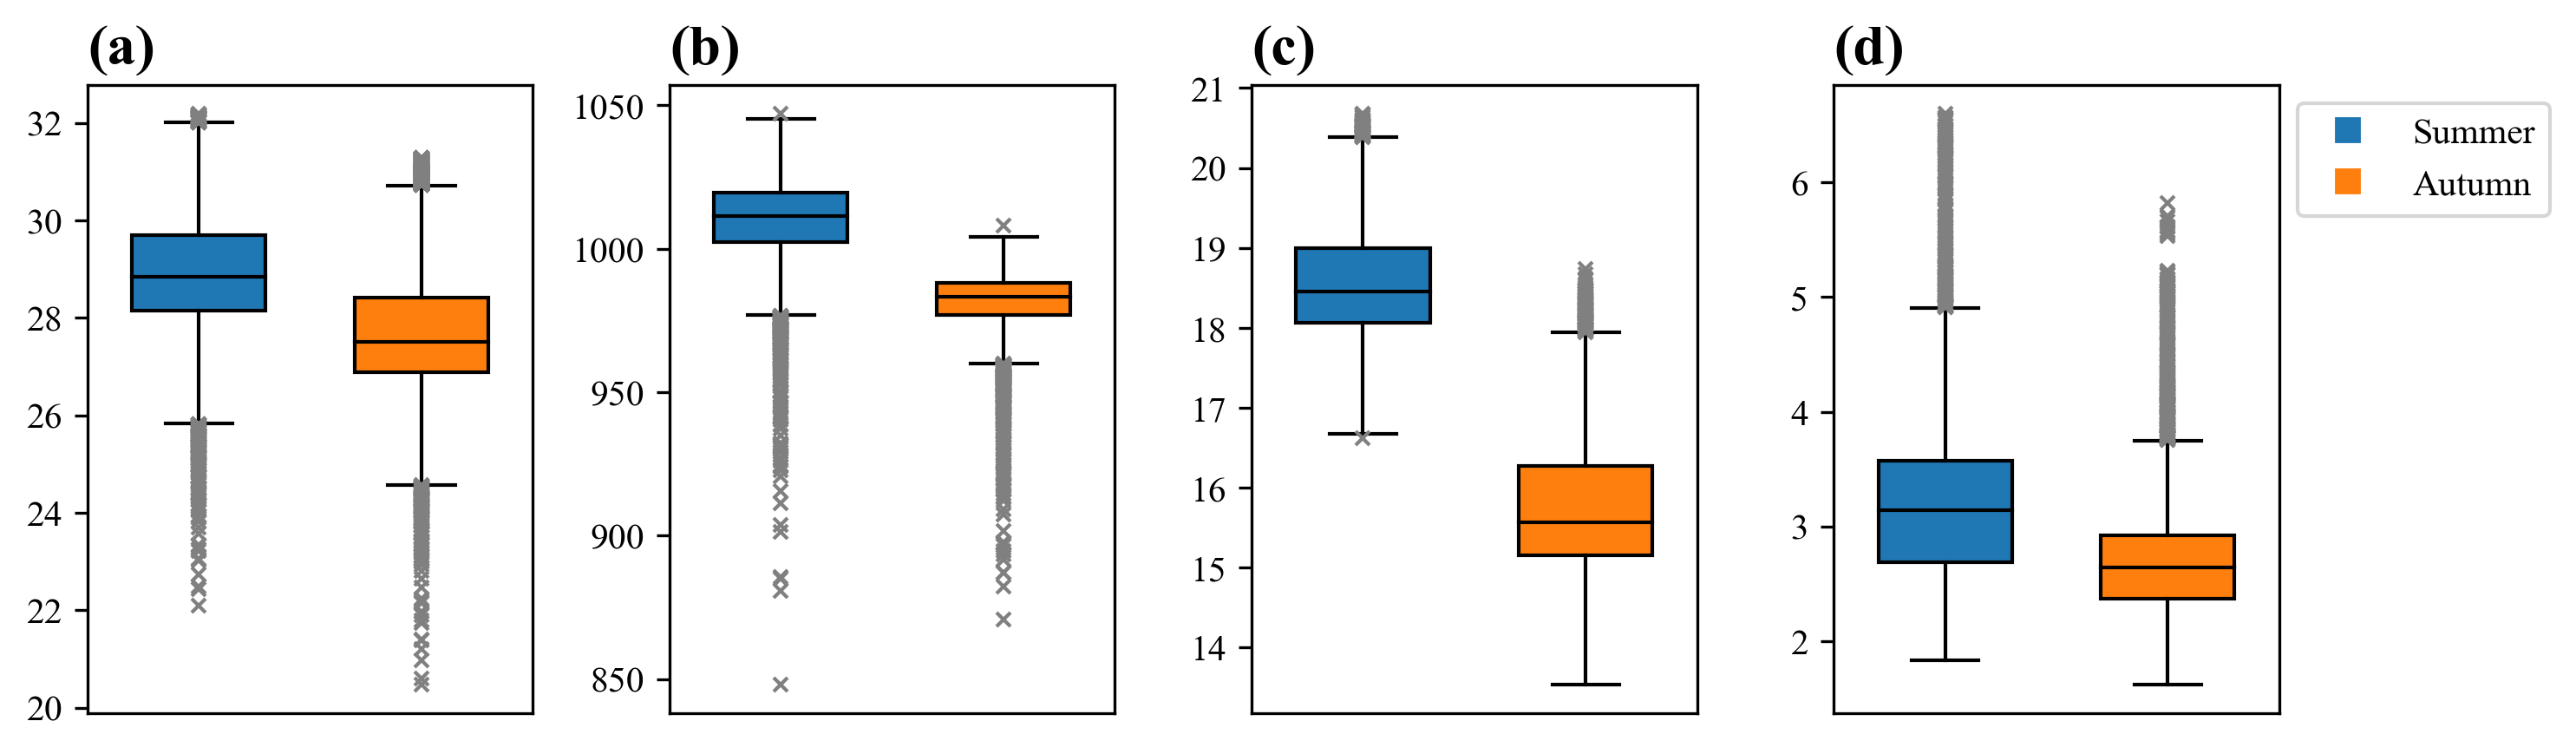

In [5]:
# Plot settings
medianprop = {'linestyle': '-', 'color': 'black'}
flierprop = {'marker': 'x', 'markersize': 4, 'markeredgecolor': 'gray'}
strdict = {'fontsize': 16, 'fontweight': 'bold'}

# Create subplots
fig, ax = plt.subplots(1, len(vars), figsize=(10, 3), dpi=300)

# Iterate over variables
for i, variable in enumerate(vars):
    box_data = [summer[variable], autumn[variable]]

    # Create boxplot
    box = ax[i].boxplot(box_data, patch_artist=True, widths=0.6,
                        medianprops=medianprop, showfliers=True, flierprops=flierprop)

    # Set box colors
    colors = ['tab:blue', 'tab:orange']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Set subplot title
    ax[i].set_title(f'({chr(97 + i)})', loc='left', fontdict=strdict)
    ax[i].set_xticks([])
    
# Create legend handles and labels
legend_handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=8) for color in ['tab:blue', 'tab:orange']]
legend_labels = ['Summer', 'Autumn']
ax[-1].legend(legend_handles, legend_labels,bbox_to_anchor=(1, 1))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


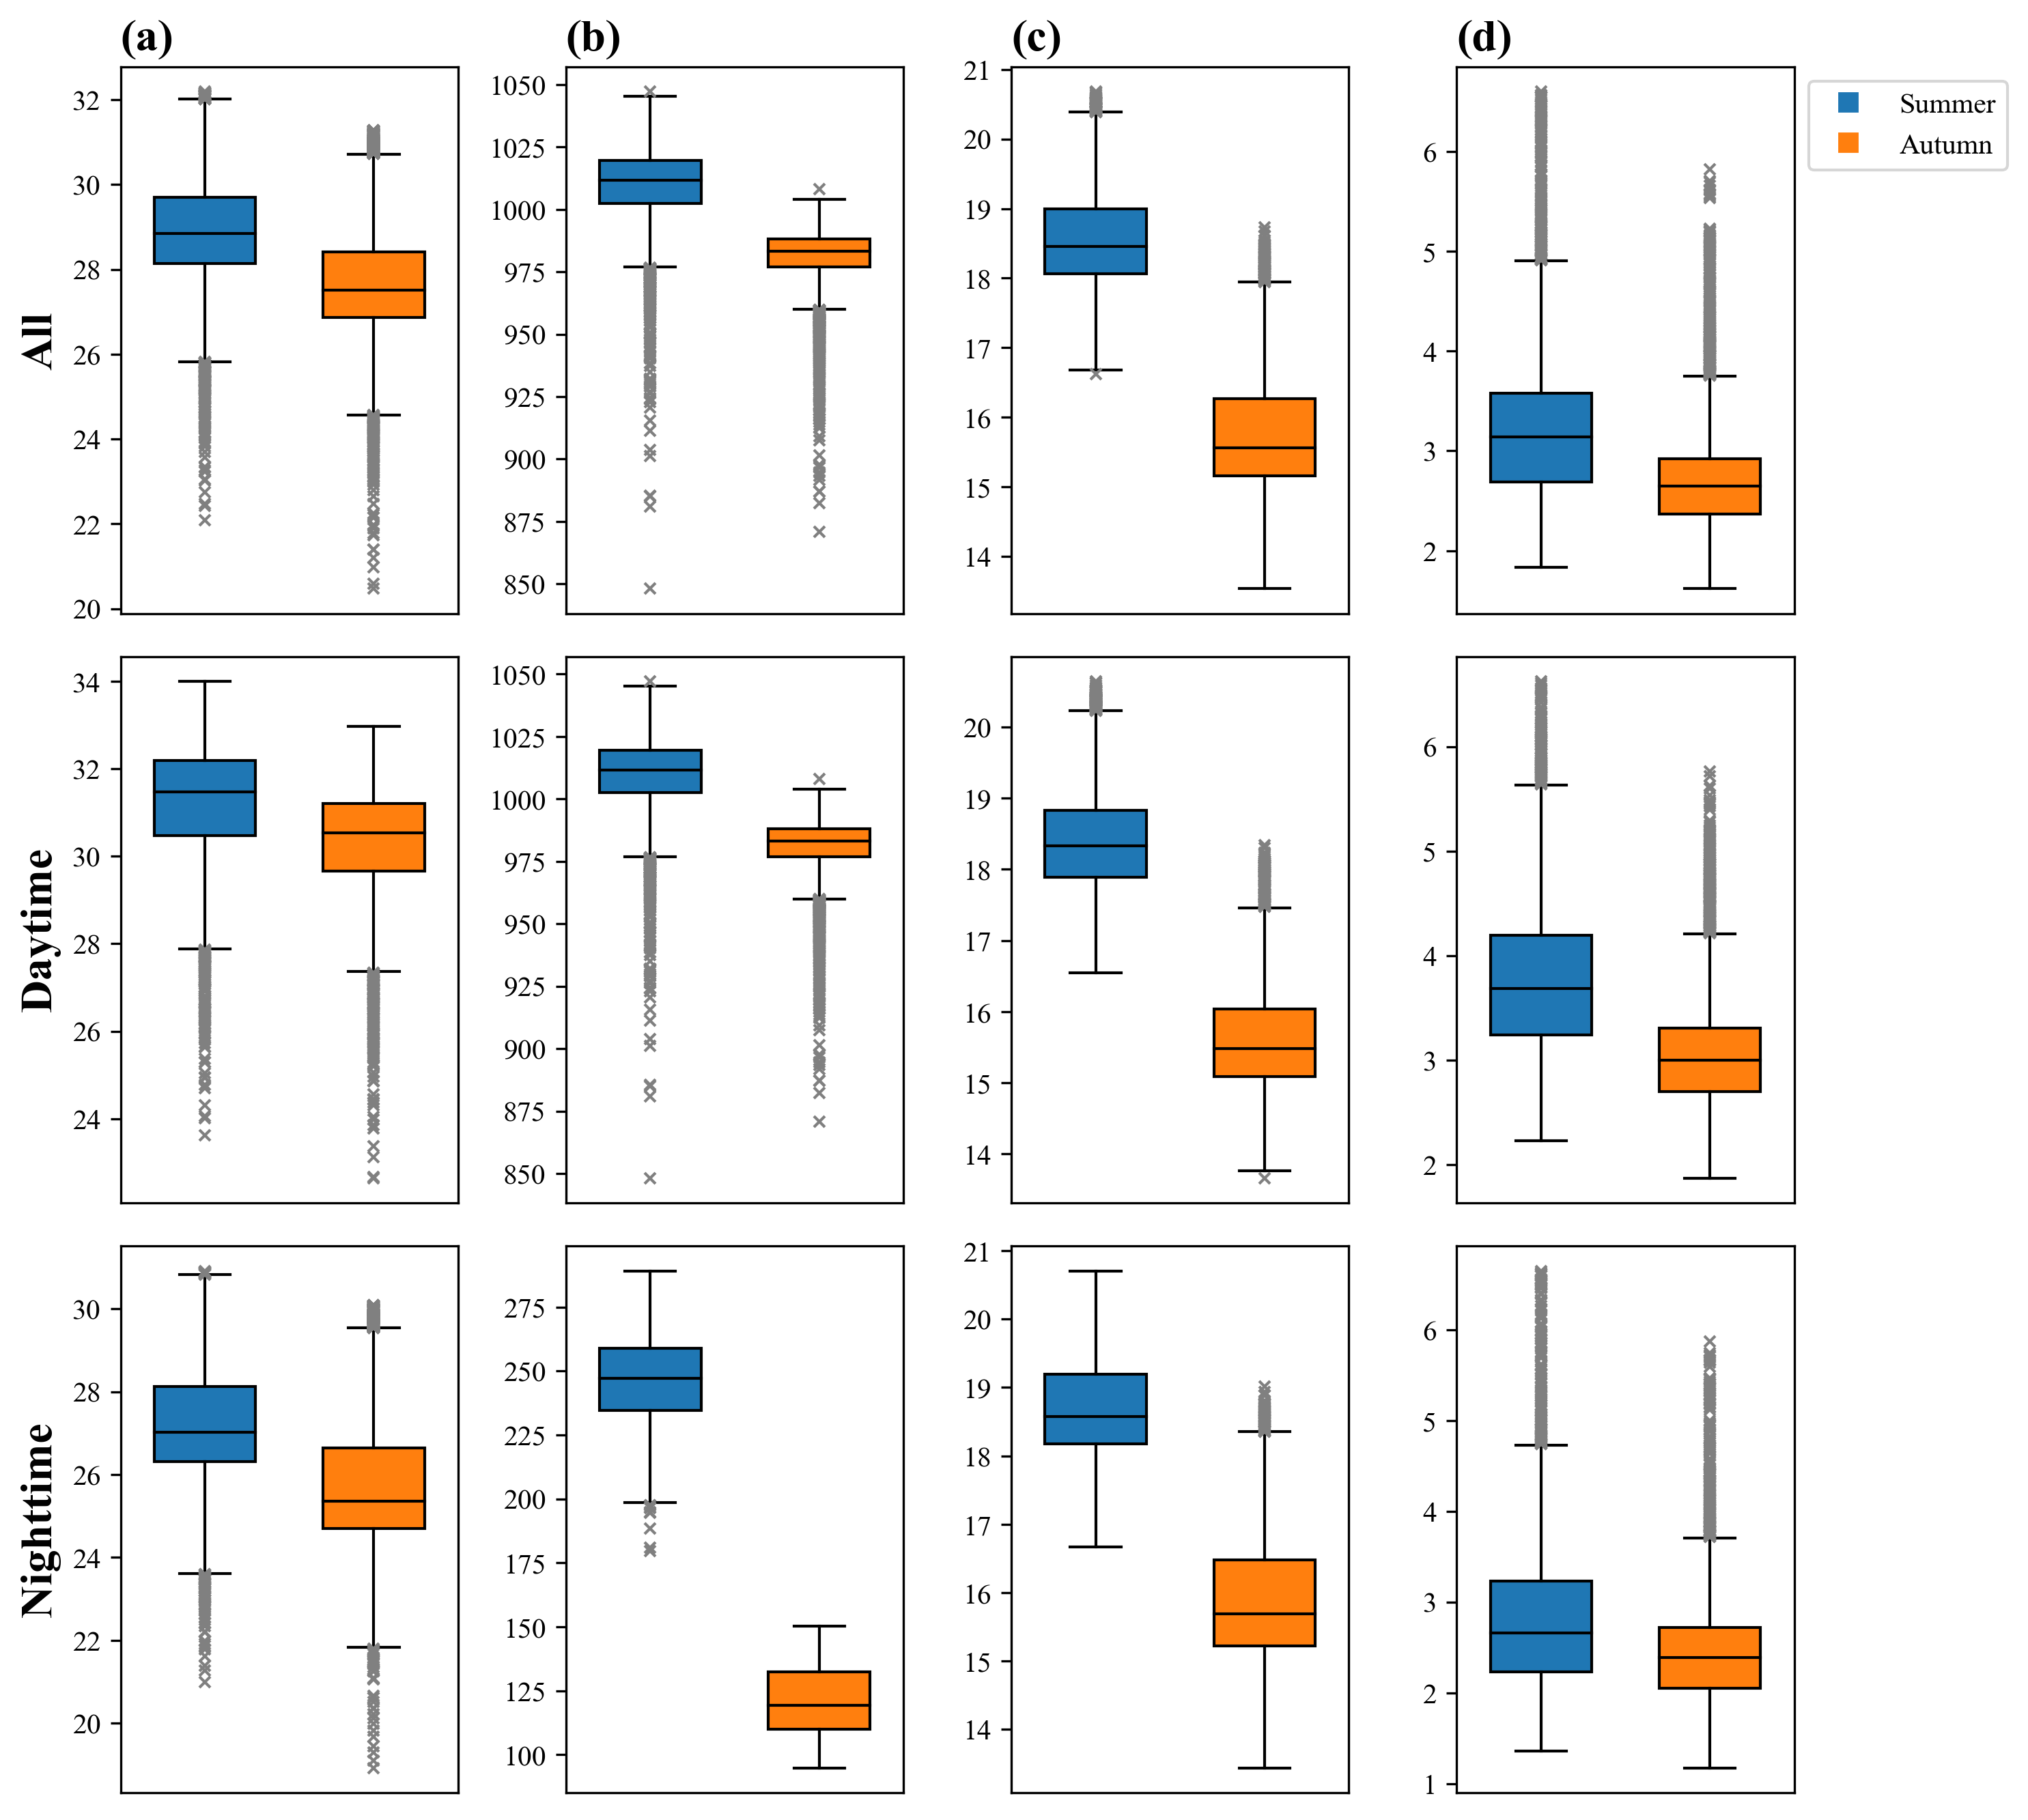

In [6]:
# Plot settings
medianprop = {'linestyle': '-', 'color': 'black'}
flierprop = {'marker': 'x', 'markersize': 4, 'markeredgecolor': 'gray'}
strdict = {'fontsize': 16, 'fontweight': 'bold'}

# Create subplots
fig, axs = plt.subplots(3, len(vars), figsize=(10, 9), dpi=300)

# Iterate over variables and rows
for j, variable in enumerate(vars):
    for i, period in enumerate(['', '_day', '_night']):
        box_data = [summer[f"{variable}{period}"], autumn[f"{variable}{period}"]]

        # Create boxplot
        box = axs[i, j].boxplot(box_data, patch_artist=True, widths=0.6,
                                medianprops=medianprop, showfliers=True, flierprops=flierprop)

        # Set box colors
        colors = ['tab:blue', 'tab:orange']
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)

        # Set subplot title
        if i == 0:
            axs[i, j].set_title(f'({chr(97 + j)})', loc='left', fontdict=strdict)
        axs[i, j].set_xticks([])

# Add legend with adjusted position
legend_handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=8) for color in ['tab:blue', 'tab:orange']]
legend_labels = ['Summer', 'Autumn']
axs[0, -1].legend(legend_handles, legend_labels, bbox_to_anchor=(1, 1))

axs[0,0].set_ylabel('All', fontdict=strdict)
axs[1,0].set_ylabel('Daytime', fontdict=strdict)
axs[2,0].set_ylabel('Nighttime', fontdict=strdict)

plt.tight_layout()
plt.show()

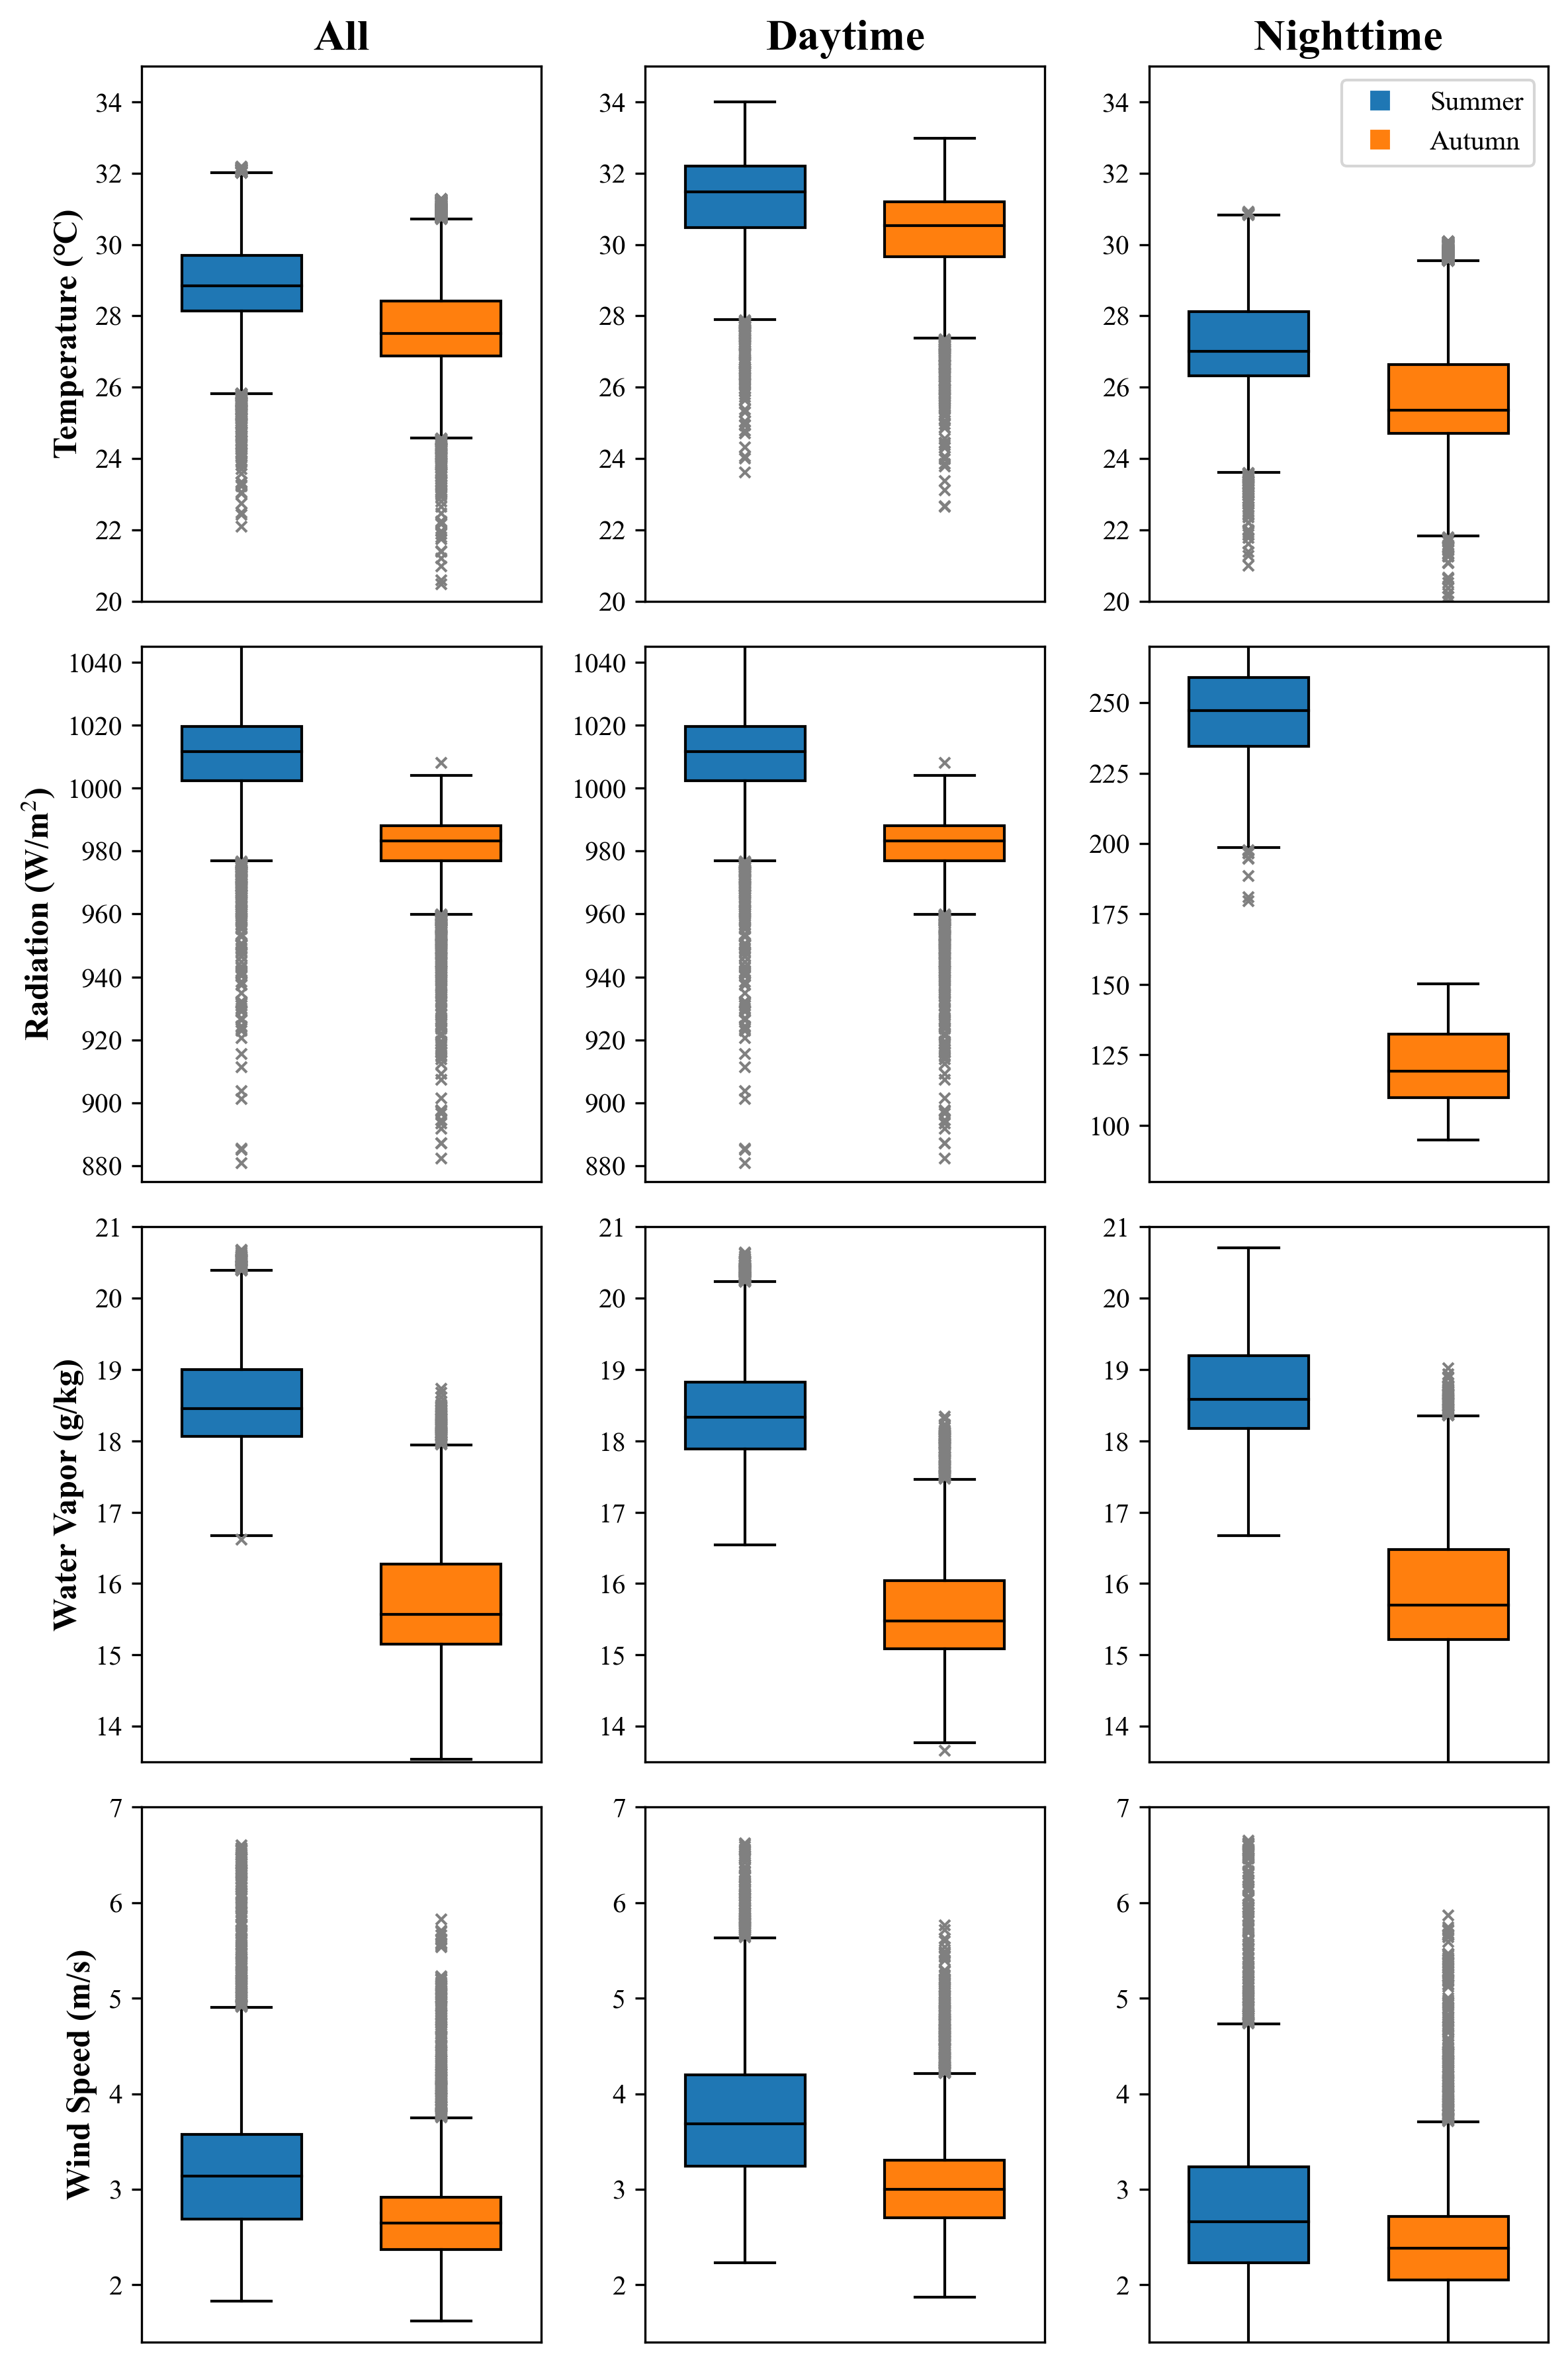

In [7]:
# Plot settings
medianprop = {'linestyle': '-', 'color': 'black'}
flierprop = {'marker': 'x', 'markersize': 4, 'markeredgecolor': 'gray'}
strdict = {'fontsize': 16, 'fontweight': 'bold'}
ylabels = ['Temperature (℃)', 'Radiation (W/m$^2$)', 'Water Vapor (g/kg)', 'Wind Speed (m/s)']
ylabeldict = {'fontsize': 12, 'fontweight': 'bold'}
# !设置上下限
ylimits = {'SFC_TMP': [20, 35], 'SOL_RAD': [875, 1045],
           'QV': [13.5, 21], 'WSPD10': [1.4, 7]}

# Create subplots
fig, axs = plt.subplots(len(vars), 3, figsize=(8, 12), dpi=300)  # Changed the size and shape

# Iterate over variables and rows
for j, variable in enumerate(vars):
    for i, period in enumerate(['', '_day', '_night']):
        box_data = [summer[f"{variable}{period}"], autumn[f"{variable}{period}"]]

        # Create boxplot
        box = axs[j, i].boxplot(box_data, patch_artist=True, widths=0.6,
                                medianprops=medianprop, showfliers=True, flierprops=flierprop)

        # Set box colors
        colors = ['tab:blue', 'tab:orange']
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)

        # Set subplot title
        if i == 0:
            axs[j, i].set_ylabel(ylabels[j], rotation=90, fontdict=ylabeldict)
        axs[j, i].set_xticks([])
        
        # Set Y limits
        if i == 2 and j == 1:
            axs[j,i].set_ylim(80,270)
        else:
            axs[j,i].set_ylim(ylimits[variable])

# Add legend with adjusted position
legend_handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=8) for color in ['tab:blue', 'tab:orange']]
legend_labels = ['Summer', 'Autumn']
axs[0, -1].legend(legend_handles, legend_labels, bbox_to_anchor=(1, 1))

axs[0, 0].set_title('All', fontdict=strdict)
axs[0, 1].set_title('Daytime', fontdict=strdict)
axs[0, 2].set_title('Nighttime', fontdict=strdict)

plt.tight_layout()
plt.show()


## 补充变化百分比

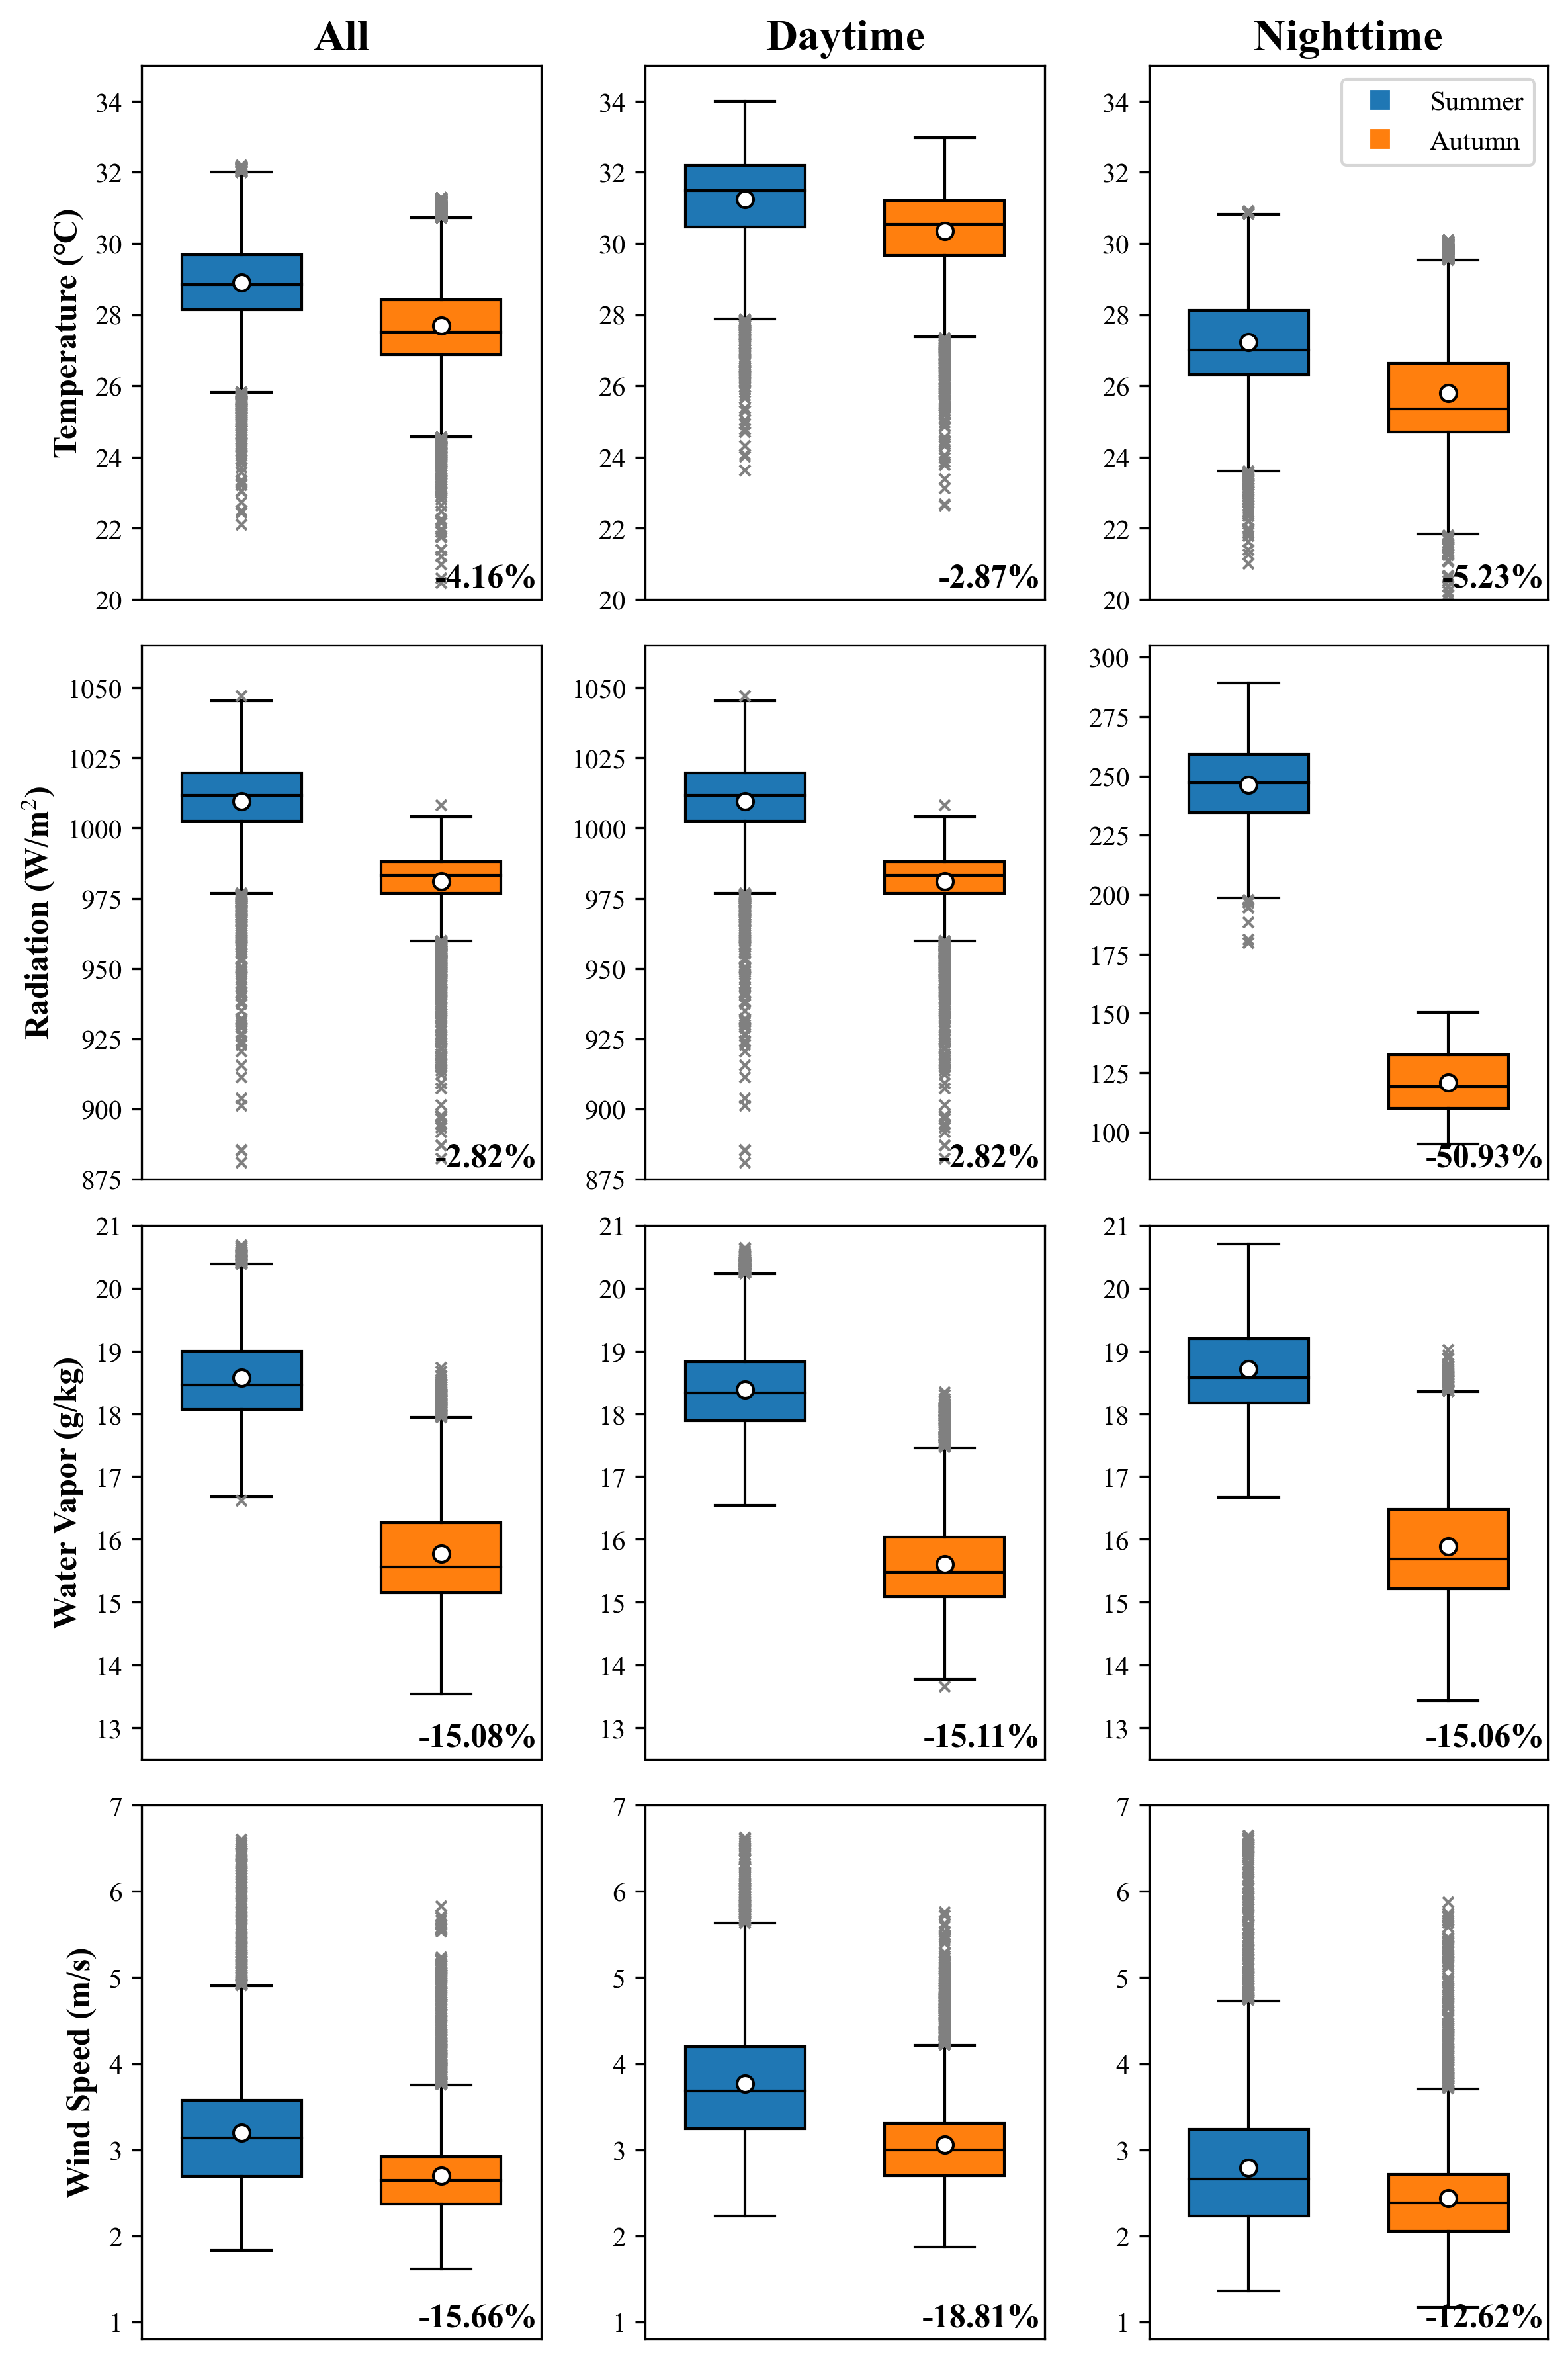

In [5]:
# Plot settings
medianprop = {'linestyle': '-', 'color': 'black'}
flierprop = {'marker': 'x', 'markersize': 4, 'markeredgecolor': 'gray'}
strdict = {'fontsize': 16, 'fontweight': 'bold'}
ylabels = ['Temperature (℃)', 'Radiation (W/m$^2$)', 'Water Vapor (g/kg)', 'Wind Speed (m/s)']
ylabeldict = {'fontsize': 12, 'fontweight': 'bold'}
textdict = {'fontsize': 12, 'fontweight': 'bold','ha':'right','va':'bottom'}
# !设置上下限
ylimits = {'SFC_TMP': [20, 35], 'SOL_RAD': [875, 1065],
           'QV': [12.5, 21], 'WSPD10': [0.8, 7]}

# Create subplots
fig, axs = plt.subplots(len(vars), 3, figsize=(8, 12), dpi=300)  # Changed the size and shape

# Iterate over variables and rows
for j, variable in enumerate(vars):
    for i, period in enumerate(['', '_day', '_night']):
        box_data = [summer[f"{variable}{period}"], autumn[f"{variable}{period}"]]

        # Create boxplot
        box = axs[j, i].boxplot(box_data, patch_artist=True, widths=0.6,
                                medianprops=medianprop, showfliers=True, flierprops=flierprop,
                                showmeans=True,meanprops={'marker':'o','markerfacecolor':'w','markeredgecolor':'black'})

        # Set box colors
        colors = ['tab:blue', 'tab:orange']
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)

        # Set subplot title
        if i == 0:
            axs[j, i].set_ylabel(ylabels[j], rotation=90, fontdict=ylabeldict)
        axs[j, i].set_xticks([])
        
        # Set Y limits
        if i == 2 and j == 1:
            axs[j,i].set_ylim(80,305)
        else:
            axs[j,i].set_ylim(ylimits[variable])

        # Calculate and add percentage change
        percentage_change = ((np.nanmean(box_data[1]) - np.nanmean(box_data[0])) / np.nanmean(box_data[0])) * 100
        if percentage_change > 0:
            percent = f'+{percentage_change:.2f}%'
        else:
            percent = f'{percentage_change:.2f}%'
        axs[j, i].text(0.99, 0.01, percent, transform=axs[j, i].transAxes,**textdict)

# Add legend with adjusted position
legend_handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=8) for color in ['tab:blue', 'tab:orange']]
legend_labels = ['Summer', 'Autumn']
axs[0, -1].legend(legend_handles, legend_labels, bbox_to_anchor=(1, 1))

axs[0, 0].set_title('All', fontdict=strdict)
axs[0, 1].set_title('Daytime', fontdict=strdict)
axs[0, 2].set_title('Nighttime', fontdict=strdict)

plt.tight_layout()
plt.show()
